## *Install and Import libraries*

In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=9b7d86df0df6a7f515a634ceb2dfb2239e87e7b476fd04efe0c78766ac2fb942
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [ ]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=d87f565511c988146ef980a20bccfa50e0baca816a786dd707981664e4ba548a
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [5]:
pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import json
import csv
import random
import string
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster.elbow import kelbow_visualizer
from collections import defaultdict
from datetime import timedelta
from scipy import stats
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import prince
import langid
import swifter

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2 - Grouping user together**

## Getting our data

We access data found in this dataset. In our spefic case the **dataset refer to Netflix audience behaviour and UK movies.**
The dataset covers user behaviour on Netflix from users in the UK to opted-in to have their anonymized browsing activity tracked.

It only includes desktop and laptop activity (which Netflix estimate is around 25% of global traffic) and is for a fixed window of time (January 2017 to June 2019, inclusive).

We may remark that data is not trusted by the platform itself but of course is relevant for *media economics.*


In [15]:
dataset = pd.read_csv('/content/drive/MyDrive/ADM4/vodclickstream_uk_movies_03.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


We change default value to zero for missing values of `duration` variable

In [16]:
# setting to 0 default missing values as could compromise future averages when doing feature engeneering
dataset['duration'] = dataset['duration'].map(lambda x: 0 if x ==-1 else x)

In [ ]:
dataset.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user.


## Get **favorite genre**, according to time spent seeing that genre films (duration)

> To get the favorite genre of a user we first create of set of genres

>and than we count for each user which is the most seen (based on the duration of the films)

As we want to compute the favorite films considering *duration* column.
> **We see there're a lot of 0.0 duration** probably due to the fact that a customer clicked but didn't started watching the film.

There are 350382  empty duration row which we will not consider to retrieve the favorite genre of a user
### Filter Data

In [ ]:
# For each row we have now a list of the genres and store to a new variable in the dataset
dataset['genres_list'] = dataset.genres.apply(lambda row: [word.strip() for word in row.split(',')])

In [ ]:
# Groupby su 'user_id' e filter for 'duration' > 0
#gdf = dataset[dataset['duration']>0.0]
gdf = dataset[dataset['duration'] != '']
#gdf = dataset[dataset['duration'] > 0.0].dropna(subset=['duration'])
gdf['duration'] = pd.to_numeric(gdf['duration'], errors='coerce')
gdf.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]"
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]"
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]"
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]"
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Family,..."


#### Approach

As each films has multiple labels referring to the genre we probabily want to make a dictionary from the set of genres created, update the count with the duration if that film belongs to that genre and return the favorite genre for each user.

To get the first feature we will:

1.   Create the dictionary {   (`user_id`, `genre`): `total_duration_spent_for_that_genre`}
2.   From this we create a new vocabulary where we have for each user the maximum duration and all associated genres. It occures to have more that one genres as a film can have multiple labels or more films same maximum duration.

> This dictionary will look like
{`user_id`: [`total_duration`, [ `genre1`,`genre2`,`genre3`]}
3. We convert it to a DataFrame and merge to the gf - dataframe merged by user_id



In [ ]:
# I create a dictionary were I store the genre and the total time spent on that genre
# for each user.

# Create a defaultdict to store genre durations for each user
genres_dict = defaultdict(int)

# Iterate over rows in genre_df
for index, row in gdf.iterrows():
    user_id = row['user_id']
    duration = row['duration']

    # Update the genre durations in the dictionary
    for genre in row['genres_list']:
        genres_dict[user_id, genre] += duration

In [ ]:
# An example of a key and a result of the dictionary
genres_dict[('c4e13ce589', 'Adventure')]

55279.0

In [ ]:
# Create the second dictionary to search the genre which maximum duration
column_fav_genres = defaultdict()
# Iterate over each user
for user,user_genres in genres_dict.keys():
    # Get duration
    duration = genres_dict[user,user_genres]
    # We update the dictionary with genres if those also have the maximum duration
    if user in column_fav_genres:
        # Storing the duration
        if column_fav_genres[user][0] == duration :
            # And the user
            column_fav_genres[user][1].append(user_genres)

        else:
            # Or replace the list of genre with maximum duration for each user when a find a greater duration
            if column_fav_genres[user][0]>duration:
                column_fav_genres[user] = [column_fav_genres[user][0], [user_genres]]
    # Otherwise we create a new label in the dictionary
    else:
        column_fav_genres[user] = [duration, [user_genres]]


In [ ]:
column_fav_genres['e81837c873']

[1474.0, ['Action', 'Drama', 'Thriller']]

In [ ]:
# Creating a new dictionary only for the favorite genres
for user in column_fav_genres.keys():
    column_fav_genres[user] = column_fav_genres[user][1]

In [ ]:
column_fav_genres['d7059ace40']

['Adventure', 'Family', 'Fantasy', 'Animation']

In [ ]:
# Creating a dataset from it
fav_genres = pd.DataFrame(column_fav_genres.items(), columns=['user_id','favorite_genres'])

In [ ]:
fav_genres.head()

,user_id,favorite_genres
0,1dea19f6fe,"[Comedy, Drama, Romance]"
1,544dcbc510,[Adventure]
2,7cbcc791bf,[Romance]
3,ebf43c36b6,[Comedy]
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu..."


## **average click duration**

Here we simply create a dataframe and computed the average duratioon of a click

In [45]:
average_click = pd.DataFrame()
average_click = average_click.assign(average_click = lambda x :dataset.groupby(by='user_id').duration.mean()).reset_index()

average_click.head()

,user_id,average_click
0,00004e2862,0.000000
1,000052a0a0,2024.166667
2,000090e7c8,0.000000
3,000118a755,0.000000
4,000296842d,9663.500000



## **time of day the user spents most of the time**

Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)


In [33]:
dataset.datetime = pd.to_datetime(dataset.datetime)
dataset.release_date = pd.to_datetime(dataset.release_date, errors='coerce')

In [ ]:
dataset['hourofday'] = 0
dataset['hourofday'] = dataset.datetime.dt.hour

dataset.groupby(by=['user_id','hourofday'])


I create a dictionary as the following:
> {`user_id`: `duration_morning`,`duration_afternoon`,`duration_night`}
were all duration as considered as the the sum of the duration if `hourofday` is in the respective bins (slot of time).

Notice that we are considering only the starting point as information

Furthermore we split a in day in morning, afternoon and night in the following way:

part of the day (hourofday)=
\begin{cases}
\text{morning} \qquad \quad hourofday \in[05,12] \\
\text{afternoon}   \qquad hourofday \in[12,21] \\
\text{night} \qquad \qquad hourofday \in[21,05] \\
\end{cases}


In [ ]:
# Define a dictionary to store each total duration for each part. of the day
find_max_duration = defaultdict(lambda: [0,0,0])


# Iterating over the dataset to get all the information
for index,row in dataset.iterrows():
    user_id = row['user_id']
    hour = row['hourofday']
    duration = row['duration']
    # Add opportunly sum up in the corrispondence position in the list
    if 5<=hour<12:
        # list[0] if MORNING
        find_max_duration[user_id][0] += duration
    elif 12<=hour<21:
        # list[1] for AFTERNOON
        find_max_duration[user_id][1] += duration
    elif 21<=hour or hour<5:
        # list[2] if NIGHT
        find_max_duration[user_id][2] += duration

In [ ]:
# An example
find_max_duration['7cbcc791bf']

[0, 21496.0, 3816.0]

In [ ]:
# Create a new dictionary were for each user I return 'Morning/Afternoon/Night'
# leveraging the dictionary fin_max_duration
max_hourofday = defaultdict()

i=0
for id in find_max_duration.keys():
    max_list = find_max_duration[id].index(max(find_max_duration[id]))
    if max_list ==0:
        max_hourofday[id] = 'Morning'
    if max_list ==1:
        max_hourofday[id] = 'Afternoon'
    if max_list ==2:
        max_hourofday[id] = 'Night'

In [ ]:
# Creating a DataFrame from the dictionary
timeofday = pd.DataFrame(list(max_hourofday.items()), columns=['user_id', 'timeofday'])

In [ ]:
timeofday.head()

,user_id,timeofday
0,1dea19f6fe,Morning
1,544dcbc510,Afternoon
2,7cbcc791bf,Afternoon
3,ebf43c36b6,Afternoon
4,a57c992287,Afternoon



### **old movie lover/new school user**

Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

We set this variable to `oldmovies` when an user saw more films released before 2010 rather then film released after that year.

In [ ]:
dataset['oldmovie'] = False
dataset['oldmovie'] = dataset.release_date.dt.year < 2010

# Group by 'user_id' and calculate the sum of True and False for each user
user_preference = dataset.groupby('user_id')['oldmovie'].sum()

oldmovie_df = pd.DataFrame(user_preference).reset_index()
# Create a new column 'oldmovie_preference' based on the condition
oldmovie_df['oldmovie'] = dataset['user_id'].map(user_preference > (dataset.groupby('user_id')['oldmovie'].count() - user_preference))

# Convert the boolean values to 'oldmovies' or 'newmovies'
oldmovie_df['oldmovie'] = oldmovie_df['oldmovie'].map({True: 'oldmovies', False: 'newmovies'})



In [ ]:
oldmovie_df.head()

,user_id,oldmovie
0,00004e2862,oldmovies
1,000052a0a0,newmovies
2,000090e7c8,newmovies
3,000118a755,newmovies
4,000296842d,newmovies


## **average time**
Average time spent a day by the user (considering only the days he logs in)

> we decide not to drop values with 0-duration as they are computed in the mean

In [ ]:
df1 = pd.DataFrame()
df1[['days', 'averagetime_day', 'user_id']] = dataset[['datetime', 'duration', 'user_id']]

# Extract the date from the 'datetime' column
df1['date'] = df1['days'].dt.date

# Group by date and perform your desired aggregation
grouped_data = df1.groupby(by = ['date','user_id']).agg({'averagetime_day': 'mean'}).reset_index().drop(columns=['date'])
# Group by user_id and calculate the mean of 'averagetime_day'
user_avg_data = grouped_data.groupby('user_id')['averagetime_day'].mean().reset_index()

In [38]:
user_avg_data['averagetime_day'] = user_avg_data['averagetime_day'].transform(lambda x :x/60)

In [39]:
user_avg_data.head()

,user_id,averagetime_day
0,00004e2862,0.000000
1,000052a0a0,44.871296
2,000090e7c8,0.000000
3,000118a755,0.000000
4,000296842d,143.319444


## We finally have all our 5 variables + `user_id`

In [ ]:
# We merge ur five variables
merged_df = pd.merge(fav_genres, average_click, on='user_id')
merged_df = pd.merge(merged_df, oldmovie_df, on='user_id')
merged_df = pd.merge(merged_df, user_avg_data, on='user_id')
merged_df = pd.merge(merged_df, timeofday, on='user_id')


In [48]:
merged_df

,user_id,favorite_genres,average_click,oldmovie,averagetime_day,timeofday
0,1dea19f6fe,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning
1,544dcbc510,[Adventure],2024.166667,newmovies,44.871296,Afternoon
2,7cbcc791bf,[Romance],0.000000,newmovies,0.000000,Afternoon
3,ebf43c36b6,[Comedy],0.000000,newmovies,0.000000,Afternoon
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon
...,...,...,...,...,...,...
161913,45414be0ec,"[Comedy, Romance]",8495.000000,newmovies,141.583333,Morning
161914,783ec67e84,"[Biography, Drama, Sport]",1785.000000,newmovies,29.750000,Morning
161915,89c715f3a4,"[Animation, Adventure, Comedy, Family, Fantasy...",40606.272727,newmovies,745.945833,Morning
161916,9207e1499b,"[Biography, Crime, Drama]",0.000000,oldmovies,0.000000,Night


In [49]:
merged_df.to_json('/content/drive/MyDrive/ADM4/5variables.json', orient='records', lines=True)

analize the isue to to mergin
- could not select duration>0 - affect averagetime_day
- some genre are not correct - [NOT AVAILABLE]

need to clean it

## *Let's add some more feature*

This should be relevant for to respect to user_id

Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).


## **1. day of the week preference**

We can imagine, and then we prove that on weekend users see more films.

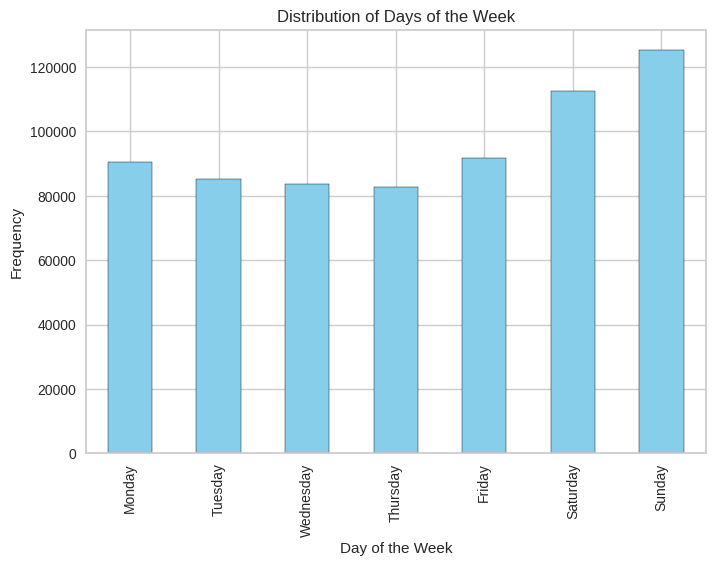

In [ ]:
# Plotting the distribution of days of the week
day_counts = week['day_of_week'].value_counts()
day_counts = day_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

day_counts.plot(kind='bar', edgecolor='black', color='skyblue')

# Setting labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Distribution of Days of the Week')

# Display the plot
plt.show()

The plot shows us what we expected, we theregr define a new *feature* `weekend` as:

weekend=
\begin{cases}
False \qquad \qquad \text{is a weekday} \\
True \qquad \qquad \text{is in the weekend} \\
\end{cases}

We can leverage this new variable to better understand the behaviour of the

In [ ]:
# Create a new DataFrame 'week' with 'day_of_week' and 'user_id'
week = dataset[['datetime', 'user_id']].copy()
week['day_of_week'] = dataset['datetime'].dt.day_name()
weekend = ['Saturday', 'Sunday']

# map into True/False values if the user watch in the film in the weekendor
week['isweekend'] = week['day_of_week'].map(lambda x : x in weekend)
# Group by 'user_id'
weekend_preference = week.groupby('user_id')['isweekend'].sum()
day_count= week.groupby('user_id')['isweekend'].count()

# Column 'weekend' based on the condition normalizing by the number of days
week['weekend'] = week['user_id'].map(
    lambda user_id: (day_count[user_id]/7 < weekend_preference[user_id]/2)
)

In [ ]:
week = week.drop(columns=['datetime', 'day_of_week','isweekend']).drop_duplicates()

In [ ]:
week

,user_id,weekend
0,1dea19f6fe,True
1,544dcbc510,True
2,7cbcc791bf,True
3,ebf43c36b6,True
4,a57c992287,False
...,...,...
671702,45414be0ec,True
671705,783ec67e84,True
671727,89c715f3a4,True
671730,9207e1499b,True


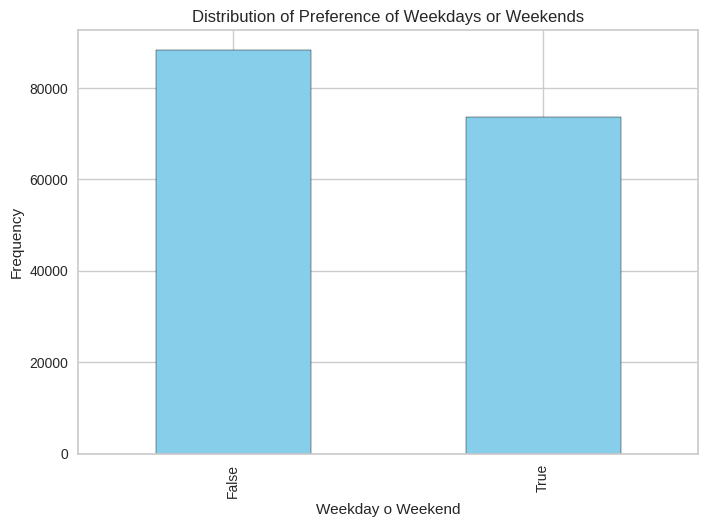

In [ ]:
weekend_weekday= week['weekend'].value_counts()
weekend_weekday.plot(kind='bar', edgecolor='black', color='skyblue')

# Setting labels and title
plt.xlabel('Weekday o Weekend')
plt.ylabel('Frequency')
plt.title('Distribution of Preference of Weekdays or Weekends')

# Display the plot
plt.show()

## **2. english title**

Most of the titles are english also if films are not from UK. Anyway there're non-english titles. Could this help s classifing the users? We'll see.

In the meantime we define the variale `count_nonenglish` which counts all film searched the user with non-english title



In [ ]:
def is_english(text):
    '''
    This function take a string of text and return wether all text is English
    Returns a boolean object
    '''
    language, confidence = langid.classify(text)
    return language == 'en'

In [ ]:
isenglish = dataset[['user_id','title']]

# Use tqdm's progress_apply for a progress bar
isenglish['isenglish'] = tqdm(dataset['title'].swifter.apply(lambda x: is_english(x)))

Pandas Apply:   0%|          | 0/671736 [00:00<?, ?it/s]

100%|██████████| 671736/671736 [00:00<00:00, 2718500.69it/s]
<ipython-input-79-ce457ab2d174>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isenglish['isenglish'] = tqdm(dataset['title'].swifter.apply(lambda x: is_english(x)))


In [ ]:
isenglish

,user_id,title,isenglish
0,1dea19f6fe,"Angus, Thongs and Perfect Snogging",True
1,544dcbc510,The Curse of Sleeping Beauty,True
2,7cbcc791bf,London Has Fallen,True
3,ebf43c36b6,Vendetta,False
4,a57c992287,The SpongeBob SquarePants Movie,True
...,...,...,...
671731,57501964fd,Oprah Presents When They See Us Now,True
671732,d4fcb079ba,HALO Legends,False
671733,4a14a2cd5a,Pacific Rim,True
671734,0b8163ea4b,ReMastered: The Two Killings of Sam Cooke,True


In [ ]:
# Evaluating the numbers of films not in english that the user searched for
isenglish['count_notenglish'] = isenglish.groupby('user_id')['isenglish'].transform(lambda x: x.count() - x.sum())

# Dropping auxiliar columns
isenglish = isenglish.drop(columns=['title','isenglish']).drop_duplicates()


In [ ]:
isenglish

,user_id,count_notenglish
0,1dea19f6fe,0
1,544dcbc510,0
2,7cbcc791bf,1
3,ebf43c36b6,5
4,a57c992287,5
...,...,...
161913,45414be0ec,1
161914,783ec67e84,0
161915,89c715f3a4,0
161916,9207e1499b,0


In [ ]:
# Converting my DataFrame to csv
isenglish.to_csv('/content/drive/MyDrive/ADM4/isenglish.csv', index=False)

In [ ]:
file_path = "/content/drive/MyDrive/ADM4/isenglish.csv"

# Read the CSV file into a DataFrame
isenglish = pd.read_csv(file_path)


<Axes: >

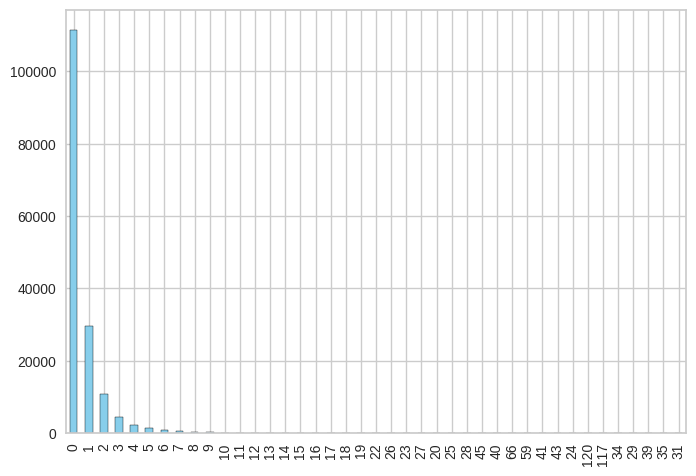

In [ ]:
english_user= isenglish['count_notenglish'].value_counts()
english_user.plot(kind='bar', edgecolor='black', color='skyblue')


### if interested in the mean (to be deleted?)

In [ ]:
isenglish['avg_isenglish'] = isenglish.groupby('user_id')['isenglish'].transform(lambda x: x.count() - x.sum()) / isenglish.groupby('user_id')['isenglish'].transform('count')


<ipython-input-46-95e9db6844e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isenglish['avg_isenglish'] = isenglish.groupby('user_id')['isenglish'].transform(lambda x: x.count() - x.sum()) / isenglish.groupby('user_id')['isenglish'].transform('count')


## **3. series addiction**

If an user saw at least a film which belongs to a series

First of all **we define a film to be part of a series if**:

> in the title there is a number (this decision was taken looking at the unique values of the titles) which:
  >> does not start at the beginning of the title

  >> is not a percentage (e.g. 100)
  
  >> is not a float number like (1.0) or (40,000)

  >> 1st (appears not to assign the number of series of a film)

  >> 3D information qithin the title

  >> mixed string like QR45EE700

  >> digits more that 3 digits, assuming that a series of film will not exceed 999

  >> reference to years like 90s or '42

All examples cited were occurenced of real tiles in the dataset

Finally we define the feature through boolean values as follows:


series_addicted=
\begin{cases}
False \qquad \qquad \text{never seena film which belongs to a series} \\
True \qquad \qquad \text{has seen at least one series} \\
\end{cases}


In [ ]:
series = dataset[['title','user_id']].copy()

def remove_punctuation(input_string):
    '''
    Function wich return a string
    '''
    translation_table = str.maketrans("", "", string.punctuation)
    no_punctuation = input_string.translate(translation_table)
    return no_punctuation

def process_title(title):
    '''
    Finds wethere a film belongs or not to a series of films based on the ruled decided
    for this dataset
    '''
    joined_title = title
    joined_title = re.sub(r"\([^)]*\)|3D|\d{1,3}%|\d{1,2}[,|.]\d{1,3}|\d{2}s|'\d{2}|\d{1,3}%|\d{1,3}[st|th|rd]", '', joined_title)
    joined_title1 = ''.join(remove_punctuation(joined_title).split())
    return not bool(re.match(r'^\d{1,4}|(\ )?[A-Z]?\d{1,6}\ ', joined_title)) and not joined_title1.isalpha()

# Create a new column 'is_series' based on those condition
series['is_series'] = series['title'].apply(process_title)

In [ ]:
# Now for each user we count how many series he saw
number_series = pd.DataFrame(series.groupby('user_id')['is_series'].sum()).reset_index()

# We convert this feature to boolean when a user has seen at least a film of the series
number_series['is_series'] = number_series['is_series'].apply(lambda x: True if x > 0 else False)

In [ ]:
number_series

,user_id,is_series
0,00004e2862,False
1,000052a0a0,False
2,000090e7c8,False
3,000118a755,False
4,000296842d,False
...,...,...
161913,fffd9bf758,True
161914,fffe7b777b,False
161915,fffeac83be,False
161916,ffff2c5f9e,False


<Axes: >

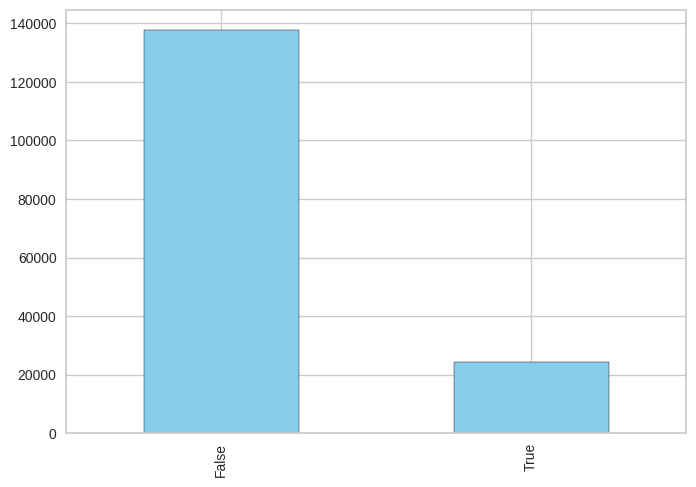

In [ ]:
series_user= number_series['is_series'].value_counts()
series_user.plot(kind='bar', edgecolor='black', color='skyblue')


## **4. film-coholic**

We define the number of films the user either saw or searched leveraging the variable `title`.

In [ ]:
# Copy the important information we need for our new variable
num_films = dataset[['user_id','title']].copy()

# Grouping by user we count the number of films
num_films['num_films'] = num_films.groupby('user_id')['title'].transform('size')

# Adjust for merging
num_films = num_films.drop(columns=['title']).reset_index(drop=True).drop_duplicates()

In [ ]:
num_films

,user_id,num_films
0,1dea19f6fe,1
1,544dcbc510,12
2,7cbcc791bf,6
3,ebf43c36b6,15
4,a57c992287,26
...,...,...
671702,45414be0ec,1
671705,783ec67e84,1
671727,89c715f3a4,1
671730,9207e1499b,1


<Axes: >

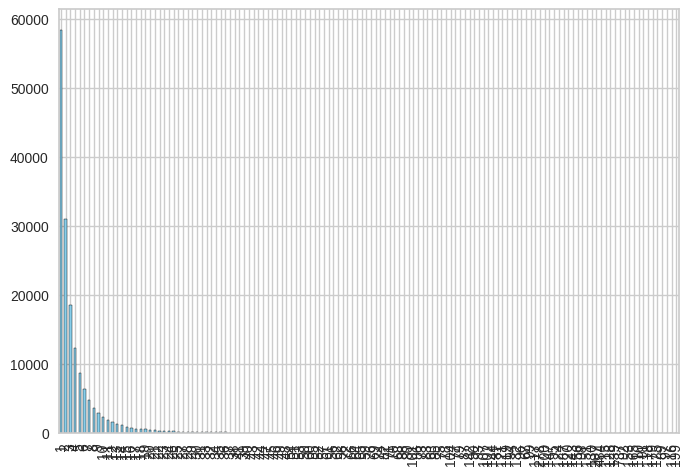

In [ ]:
film_user= num_films['num_films'].value_counts()
film_user.plot(kind='bar', edgecolor='black', color='skyblue')


## **5. movie clicker**

It seems someone is undecided about which movie to watch, but have they at least started watching one? Let's define the variable `onefilm` to capture the cinematic journeys that begin with a click but may or may not reach the final credits:


movie_clicker=
\begin{cases}
False \qquad \qquad \text{definigthly a movie-clicker} \\
True \qquad \qquad \text{has seen at least one film} \\
\end{cases}


In [ ]:
# Now for each user, check if they have seen at least one film with duration greater than 0
onefilm = dataset[['user_id', 'title', 'duration']].copy()

# Create a binary column indicating whether the user has seen at least one film (1) or not (0)
onefilm['onefilm'] = (onefilm.groupby('user_id')['duration'].transform('max') > 0).astype(bool)

# Drop duplicates to keep only unique user_id rows
onefilm = onefilm[['user_id', 'onefilm']].drop_duplicates()


In [ ]:
onefilm

,user_id,onefilm
0,1dea19f6fe,False
1,544dcbc510,True
2,7cbcc791bf,True
3,ebf43c36b6,True
4,a57c992287,True
...,...,...
671702,45414be0ec,False
671705,783ec67e84,False
671727,89c715f3a4,False
671730,9207e1499b,True


<Axes: >

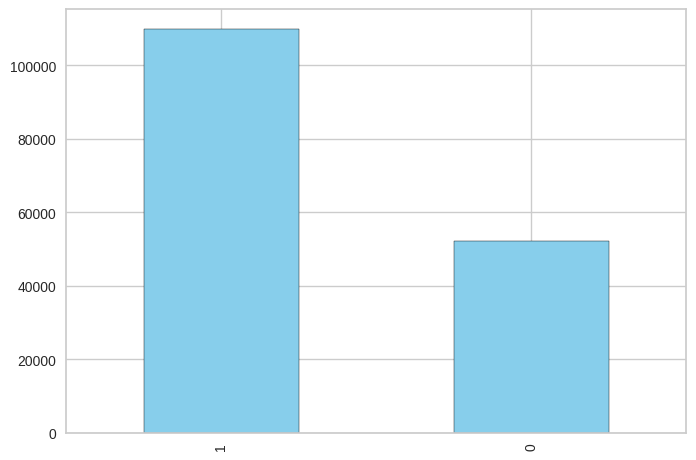

In [ ]:
onefilm_user = onefilm['onefilm'].value_counts()

onefilm_user.plot(kind='bar', edgecolor='black', color='skyblue')


## **6. unveiling the enchantment of length titles**

Ever heard of sesquipedalophobia? It's the quirky fear of long words, and while we're not here to induce word-induced anxiety, we couldn't resist a playful nod to it.

**Introducing *`avg_lentitle`* our not-so-fearsome variable that measures the average length of movie titles.**

 No need to panic; we're just unraveling the delightful dance of letters in the world of cinema. After all, a title's length may hold the secret to its allure, or perhaps it's just a whimsical journey through the labyrinth of letters

 Emphasizing inclusivity, **this metric considers all movies users searched for, providing a nuanced understanding of their preferences beyond the ones they've already watched**. This comprehensive approach enhances our ability to extract meaningful insights from their cinematic exploration

In [ ]:
# Leverage titles to find some patters in user preferences
lentitle = dataset[['user_id','title']].copy()
# Computing the length of title
lentitle['lentitle']= lentitle['title'].apply(lambda x: len(x))
# And extracting the average grouping by user
lentitle['avg_lentitle'] = lentitle.groupby('user_id')['lentitle'].transform(lambda x: x.mean().astype(int))
# Adjust dataset for merging operations
lentitle = lentitle.drop(columns=['title','lentitle']).drop_duplicates()

In [ ]:
lentitle

,user_id,avg_lentitle
0,1dea19f6fe,34
1,544dcbc510,15
2,7cbcc791bf,13
3,ebf43c36b6,13
4,a57c992287,14
...,...,...
671702,45414be0ec,18
671705,783ec67e84,14
671727,89c715f3a4,15
671730,9207e1499b,23


<Axes: >

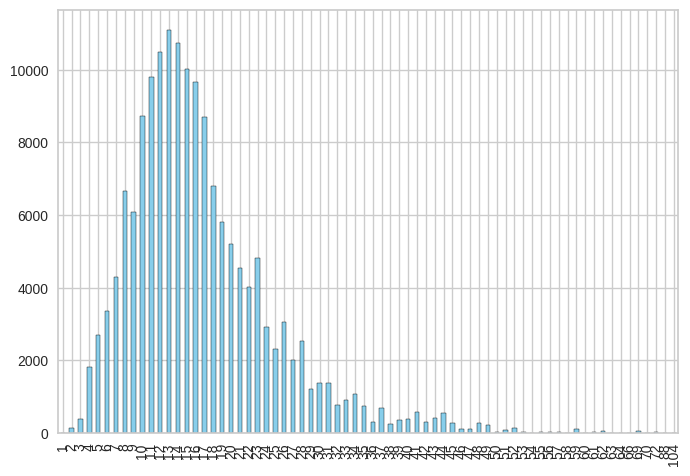

In [ ]:
title_user = lentitle['avg_lentitle'].value_counts()
title_user_sorted = title_user.sort_index()

title_user_sorted.plot(kind='bar', edgecolor='black', color='skyblue')


## **7. average duration of films seen**

Considering only the films he actually saw, we consider the duration of the time spent to see it. Notice that of course, only through our data, we cannot know if the user saw entirely the film.

We could eventually get an idea of that after looking at the result.

This isn't directly the goal of the variable. We can rather interprete it as if an user preferes long films of multiple episodes of a series eventually of go for short one.

# in minuti

In [25]:
avg_duration = dataset[['user_id', 'duration']].copy()

# Filter films with duration > 0 and count the number of films seen for each user
film_seen = dataset[dataset['duration'] > 0].groupby('user_id')['title'].count().reset_index()
film_seen.columns = ['user_id', 'film_seen']

# Merge the film_seen count with avg_duration DataFrame
avg_duration = pd.merge(avg_duration, film_seen, on='user_id')

# Calculate the average duration for each user
avg_duration['sum_duration']  = avg_duration.groupby('user_id')['duration'].transform('sum')
# Consider the average only of films actually seen and consider minutes
avg_duration['avg_duration'] = np.where(avg_duration['sum_duration'] > 0, avg_duration['sum_duration'] /(60*avg_duration['film_seen']), 0).round(3)

In [26]:
avg_duration = avg_duration.drop(columns=['duration','film_seen','sum_duration']).drop_duplicates()

In [27]:
avg_duration

,user_id,avg_duration
0,544dcbc510,155.375
12,7cbcc791bf,105.467
18,ebf43c36b6,31.392
33,a57c992287,145.148
59,c5bf4f3f57,50.990
...,...,...
591778,065de46f55,11396.167
591779,098fe851e4,69.050
591780,5463651e3a,10.000
591781,9207e1499b,709.867


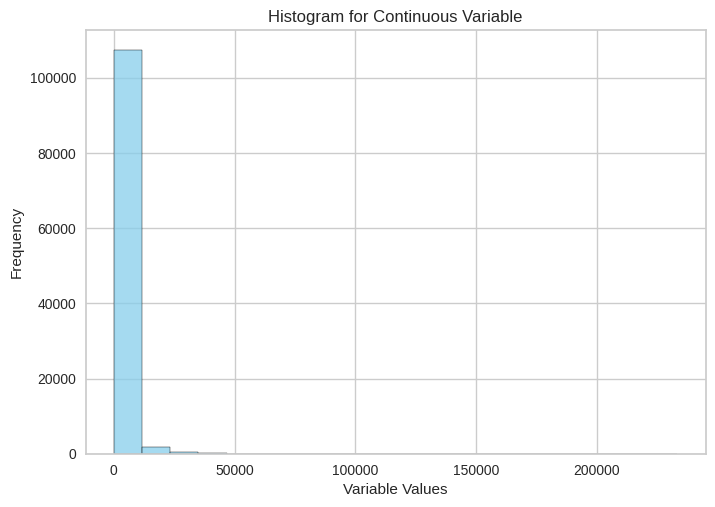

In [28]:
# Assuming 'data' is your DataFrame and 'column_name' is the column you want to visualize
sns.histplot(avg_duration['avg_duration'], bins=20, kde=False, color='skyblue')
plt.title('Histogram for Continuous Variable')
plt.xlabel('Variable Values')
plt.ylabel('Frequency')
plt.show()


## **8. genre diversity search**

True if a user see film with more than 6 (to change eventually) films. False if he see less than 6 genres in total (always the same genres)

In [ ]:
genre_diversity= dataset[['user_id','genres_list']].copy()

genre_diversity['genre_set'] = genre_diversity['genres_list'].apply(lambda x: set(x))

# Group by 'user_id' and aggregate the sets
grouped = genre_diversity.groupby('user_id')['genre_set'].agg(lambda x: set.union(*x)).reset_index()

# Counting the different genres an user searched for
grouped['number_genres'] = grouped.groupby('user_id')['genre_set'].transform(lambda x: len(*x))

# Transforming it in adicotomic variabile according to a parameter fixed at 6, whose decision was taken after observing
# a plot of gropued['genres_diversity']
grouped['genre_diversity'] = grouped['number_genres'].transform(lambda x : 'Genre Diverse' if x>4 else 'Not Genre Diverse')

In [ ]:
grouped = grouped.drop(columns=['genre_set','number_genres'])

In [ ]:
grouped

,user_id,genre_diversity
0,00004e2862,Not Genre Diverse
1,000052a0a0,Genre Diverse
2,000090e7c8,Not Genre Diverse
3,000118a755,Not Genre Diverse
4,000296842d,Not Genre Diverse
...,...,...
161913,fffd9bf758,Not Genre Diverse
161914,fffe7b777b,Not Genre Diverse
161915,fffeac83be,Genre Diverse
161916,ffff2c5f9e,Genre Diverse


## **9. time between clicks**

Calculate the average time in seconds between two consecutive clicks for each user. Some users might binge-watch content in quick succession, while others may have more spaced-out viewing habits.

In [29]:
gapclick = dataset[['user_id','datetime']].copy()

# Convert 'datetime' column to datetime format
gapclick['datetime'] = pd.to_datetime(gapclick['datetime'])

# Sort DataFrame by 'user_id' and 'datetime'
gapclick_sorted = gapclick.sort_values(by=['user_id', 'datetime'])

# Calculate the time difference between consecutive rows for each user_id
gapclick_sorted['time_diff'] = gapclick_sorted.groupby('user_id')['datetime'].diff().apply(lambda x: x.seconds/60)

# Calculate the average time gap for each user_id
gapclick_sorted['avg_clickgap']  = gapclick_sorted.groupby('user_id')['time_diff'].transform('mean').round(3)

In [30]:
gapclick = gapclick_sorted.drop(columns=['time_diff','datetime']).drop_duplicates()

In [31]:
gapclick

,user_id,avg_clickgap
223802,00004e2862,NaN
84304,000052a0a0,374.955
305472,000090e7c8,NaN
379093,000118a755,73.900
520133,000296842d,190.167
...,...,...
105488,fffd9bf758,NaN
149015,fffe7b777b,NaN
142253,fffeac83be,581.643
129867,ffff2c5f9e,17.517


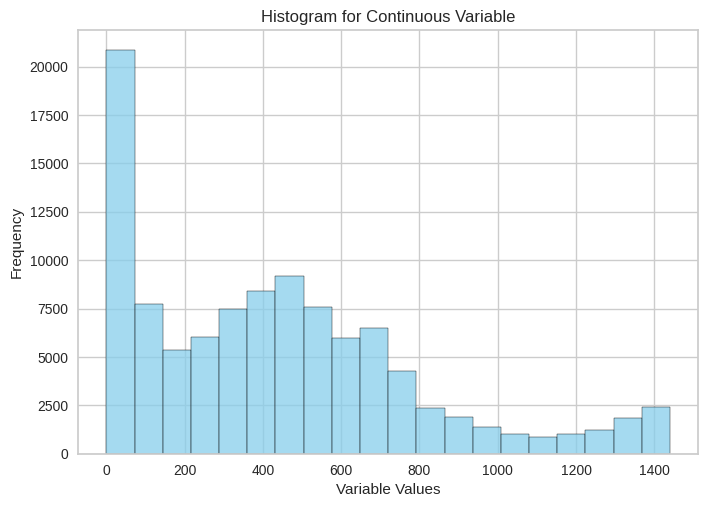

In [ ]:
# Assuming 'data' is your DataFrame and 'column_name' is the column you want to visualize
sns.histplot(gapclick['avg_clickgap'], bins=20, kde=False, color='skyblue')
plt.title('Histogram for Continuous Variable')
plt.xlabel('Variable Values')
plt.ylabel('Frequency')
plt.show()


## **10. first-day fanatic**

In this new feature we want to store if a user is a first fanatic or not examinig how muchtime from the released_date and the time he saw the film has passed.

Indeed we computed as :

$$\displaystyle \dfrac{1}{n} \sum_{i=1}^n \text{duration dicotomic} \cdot \left( \text{release date -  datetime}\right)$$

where `n` is the number of films seen by each user.

Notice that it is influnced by how many times saw that film so it can be normalized based on how many time an author has seen that film. It can be interested therefore to compute also that feature, which we're doing next.

In [ ]:
dataset[dataset['release_date']=='NOT AVAILABLE']

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
54,58827,2017-01-01 23:51:31,0.0,Minimalism: A Documentary About the Important ...,Documentary,NOT AVAILABLE,4d5756f511,83e994b53d
64,58837,2017-01-01 23:18:10,81405.0,A Perfect Day,NOT AVAILABLE,NOT AVAILABLE,9e898f41e0,8aff21d9e9
71,58844,2017-01-01 13:23:40,0.0,Minimalism: A Documentary About the Important ...,Documentary,NOT AVAILABLE,4d5756f511,0b1635a78e
113,58886,2017-01-01 12:47:30,543.0,Hunting Britain's Most Wanted,NOT AVAILABLE,NOT AVAILABLE,be096a4a5a,3cf91dd97e
118,58891,2017-01-01 17:20:26,0.0,Minimalism: A Documentary About the Important ...,Documentary,NOT AVAILABLE,4d5756f511,ea05759d9b
...,...,...,...,...,...,...,...,...
671578,730351,2019-06-30 17:27:13,8272.0,Agatha Christie's Crooked House,NOT AVAILABLE,NOT AVAILABLE,24e2aec1b8,75bfddddaf
671583,730356,2019-06-30 20:04:16,0.0,Den 12. mann,NOT AVAILABLE,NOT AVAILABLE,8551a0dbdd,5c261da852
671643,730416,2019-06-30 17:14:14,0.0,Bad Moms,NOT AVAILABLE,NOT AVAILABLE,934402ae13,06fb5a61d0
671708,730481,2019-06-30 21:10:44,3219.0,ReMastered: Who Shot the Sheriff,NOT AVAILABLE,NOT AVAILABLE,d558d9be6f,0b8163ea4b


In [ ]:
# Extract the date from the 'datetime'
#columndataset = pd.to_datetime(dataset.datetime)
dataset.datetime = pd.to_datetime(dataset.datetime)
dataset['release_date'] = dataset.apply(lambda row: row['datetime'] if row['release_date'] == 'NOT AVAILABLE' else row['release_date'],axis=1)
dataset.release_date = pd.to_datetime(dataset.release_date)

gap_time = dataset[['user_id','datetime','release_date','title']].copy()
gap_time['datetime'] = gap_time['datetime'].dt.year
gap_time['release_date'] = gap_time['release_date'].dt.year

# Calculate the time gap in years
gap_time['gap_time'] = gap_time['datetime'] - gap_time['release_date']

# Taking the average of realeased date only for the films which have non-zero gap time
gap_time['gap_time_avg'] = gap_time.groupby(['user_id','title'])['gap_time'].transform(lambda x: x.mean() if (x != 0).any() else 0)

# Take the average of film where film have gp_time_avg not zero. Some are setted to 0 when NOT AVAILABLE
gap_time['gap_time_avg'] = gap_time.groupby('user_id')['gap_time_avg'].transform(lambda x: x.mean() if (x != 0).any() else 0).round(0)


gap_time['gap_time_avg'] = gap_time['gap_time_avg'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
gap_time = gap_time.drop(columns=['datetime','release_date','gap_time','title']).drop_duplicates()

In [ ]:
gap_time

,user_id,gap_time_avg
0,1dea19f6fe,9.0
1,544dcbc510,5.0
2,7cbcc791bf,4.0
3,ebf43c36b6,6.0
4,a57c992287,6.0
...,...,...
671702,45414be0ec,0.0
671705,783ec67e84,10.0
671727,89c715f3a4,2.0
671730,9207e1499b,6.0


<Axes: >

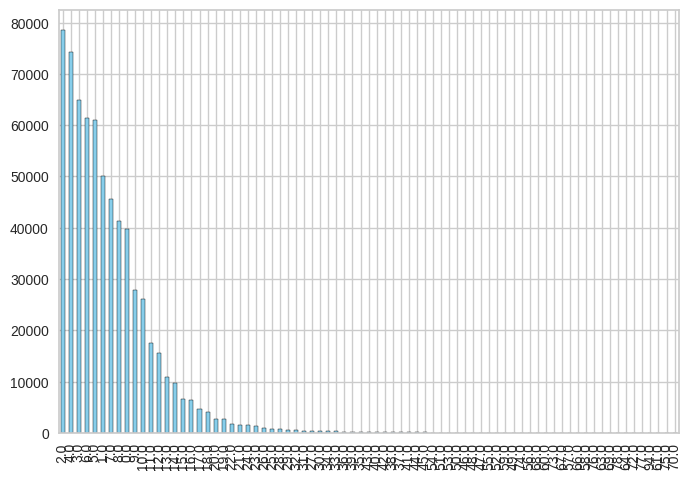

In [ ]:
gaptime_user= gap_time['gap_time_avg'].value_counts()
gaptime_user_sorted = gaptime_user.sort_index()

gaptime_user.plot(kind='bar', edgecolor='black', color='skyblue')


## final merge of the 15 features

we load the dataset we saved cointaining the first five variables

In [ ]:
file_path="/content/drive/MyDrive/ADM4/5variables.json"

# Inizializza una lista per contenere i dati JSON
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Carica l'oggetto JSON dalla riga corrente
        data = json.loads(line)
        # Aggiungi l'oggetto alla lista
        data_list.append(data)


# Now 'data' is a list of JSON objects
firstvariable = pd.DataFrame(data_list)

In [51]:
firstvariable.head()

,user_id,favorite_genres,average_click,oldmovie,averagetime_day,timeofday
0,1dea19f6fe,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning
1,544dcbc510,[Adventure],2024.166667,newmovies,44.871296,Afternoon
2,7cbcc791bf,[Romance],0.000000,newmovies,0.000000,Afternoon
3,ebf43c36b6,[Comedy],0.000000,newmovies,0.000000,Afternoon
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon


In [ ]:
# 1- and weekeday or weekend
merged_df = pd.merge(firstvariable, week, on='user_id')
# 2- title isinglish
merged_df = pd.merge(merged_df, isenglish, on='user_id')
# 3- is a series film
merged_df = pd.merge(merged_df, number_series, on='user_id')
# 4- number of films searched
merged_df = pd.merge(merged_df, num_films, on='user_id')
# 5- if an user have seen at least one film
merged_df = pd.merge(merged_df, onefilm, on='user_id')
# 6- length of the title of film
merged_df = pd.merge(merged_df, lentitle, on='user_id')
# 7- average duration of films by user_id
merged_df = pd.merge(merged_df, avg_duration, on='user_id')
# 8- genre diversity
merged_df = pd.merge(merged_df, grouped, on='user_id')
# 9- average seconds between two clicks
merged_df = pd.merge(merged_df, gapclick, on='user_id')
# 10- average seconds between two clicks
merged_df = pd.merge(merged_df, gap_time, on='user_id')

# Set user_id as index
merged = merged_df.set_index('user_id', inplace =True)

In [58]:
merged_df.head()

,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0


In [57]:
merged_df.to_json('/content/drive/MyDrive/ADM4/allvariables.json', orient='records', lines=True)


# **2.2 - Feature selection**


In [59]:
file_path="/content/drive/MyDrive/ADM4/allvariables.json"

# Initialize to store JSON file
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Load the single row of the JSON
        data = json.loads(line)
        # Add it to the list
        data_list.append(data)

# Now 'data' is a list
allvariable = pd.DataFrame(data_list)

In [60]:
allvariable.head()

,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0


**To attemp to use the variable `favorite_genre` we consider only the first element of the list of first genres**. We previously made an assumption to be conservative and try to store all favorite genre but at this point we need further assumption as we cannot store or consider frequencies of all possible duplets, triplets: indeed that choice would lead dealing with a very sparse histogram.

**We should find some more aggregate**, we try probably the simplest one:
>  taking a random element of list

>> Notice that it is more consistent than taking into account the first element as the genres in the list are ordered and therefore we then expect (and proved but not showing here) to have either a favorite genres or a genres that starts with A, B , C, D, ... such as Action, Comedy, Documentary, ...

In [89]:
allvariable2 = allvariable.copy()

# We selecet a random element in the list of favorite genres
allvariable2['first_genre'] = allvariable2['favorite_genres'].apply(lambda x: random.choice(x))

# and then drop the auxiliar column
allvariable2 = allvariable2.drop(columns = ['favorite_genres'])

In [90]:
allvariable2['first_genre'].head()

0       Comedy
1    Adventure
2      Romance
3       Comedy
4        Music
Name: first_genre, dtype: object

##  outliers removals, skewness make an introduction

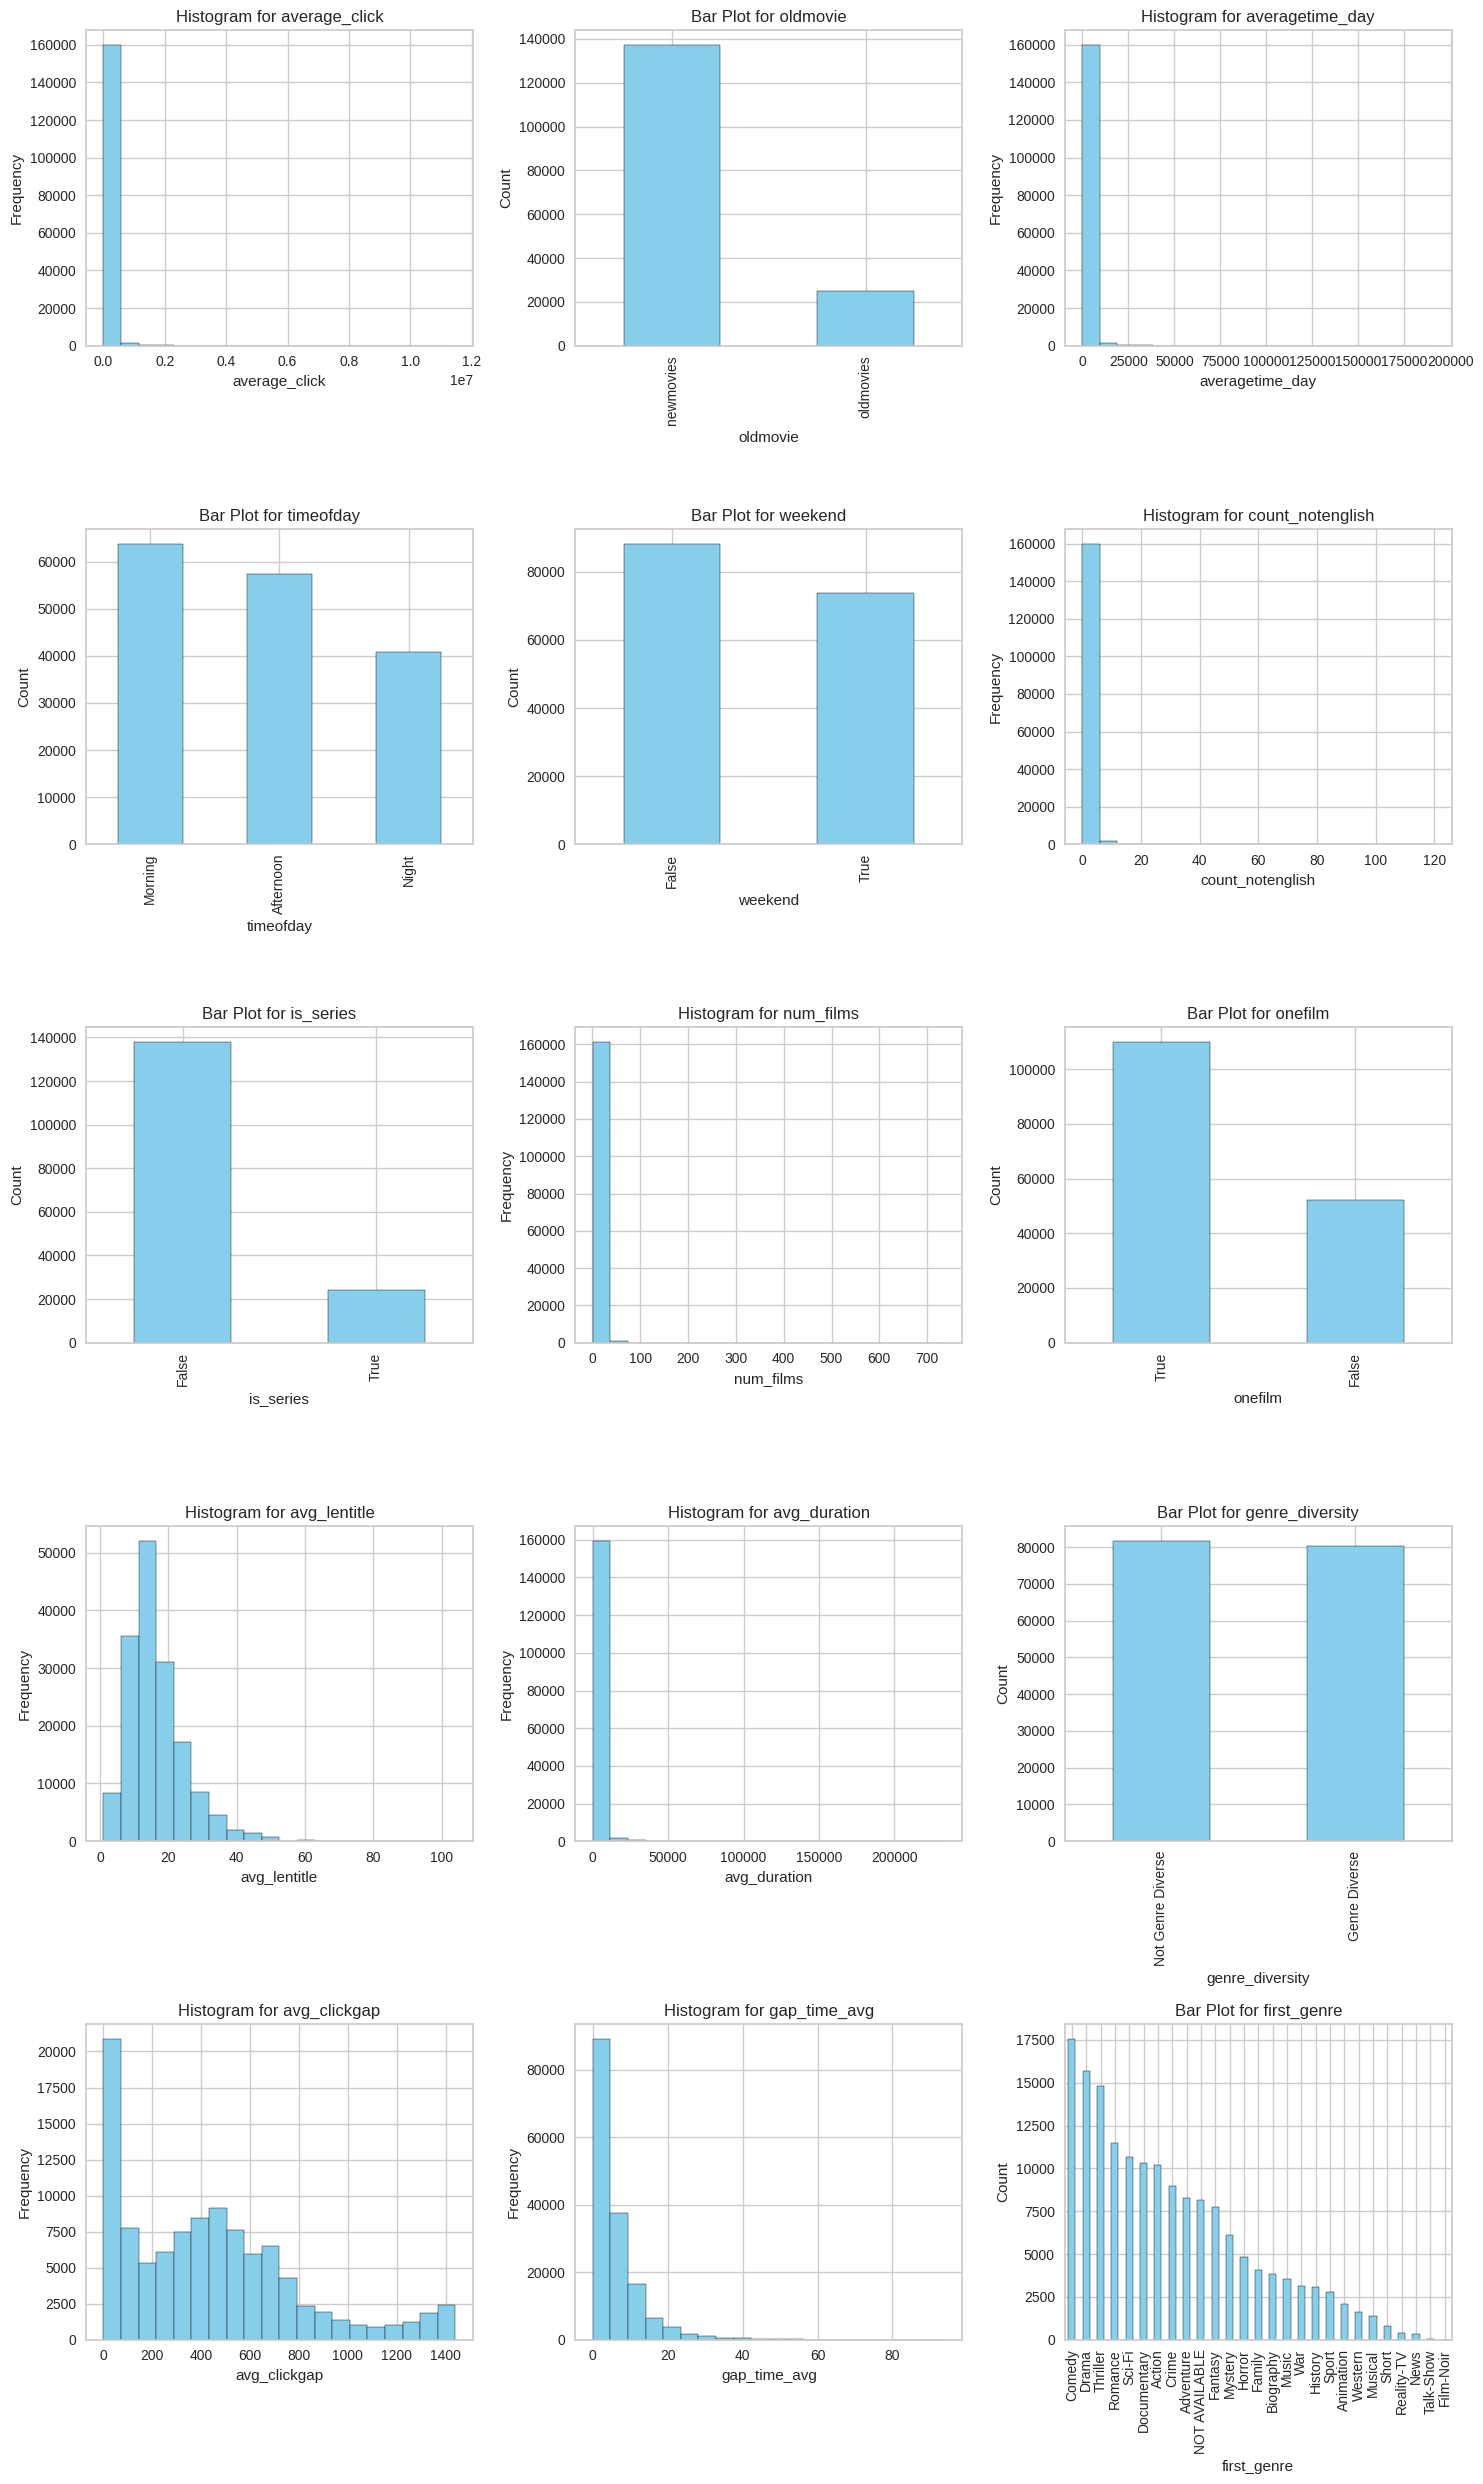

In [91]:
# Get the list of all columns
all_columns = allvariable2.columns

# Set the number of columns per row
columns_per_row = 3  # Adjust as needed

# Calculate the number of rows needed
num_rows = (len(all_columns) + columns_per_row - 1) // columns_per_row

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(all_columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row

    # Check if the column is numerical
    if allvariable2[column].dtype in ['float64', 'int64']:
        axes[row_index, col_index].hist(allvariable2[column], edgecolor='black', color='skyblue', bins=20)
        axes[row_index, col_index].set_title(f'Histogram for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Frequency')
    else:
        # For categorical columns, create a bar plot
        column_count = allvariable2[column].value_counts()
        column_count.plot(kind='bar', edgecolor='black', color='skyblue', ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'Bar Plot for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


## **Drop `outliers`**

Same variable definitly need to drop outliers, of course this a process. We start with more evident variables with outliers such as `average_duration`, `is_series`,`num_films`, `count_notenglish`, `n_repeatedfilm`, `gap_time_average`,`is_series`

In [92]:
# Select only specific columns
selected_columns = ['avg_duration', 'averagetime_day']
df_selected = allvariable2[selected_columns]

In [ ]:
# We chose a high value as data is sparse
iqr_multiplier = 3.0

# Iterate through each column in the selected DataFrame
for column in df_selected.columns:
    # Calculate the first quartile, third quartile, and interquartile range
    Q1 = df_selected[column].quantile(0.25)
    Q3 = df_selected[column].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers for the current column
    outliers = ((df_selected[column] < (Q1 - iqr_multiplier * IQR)) |
                (df_selected[column] > (Q3 + iqr_multiplier * IQR)))

    # Calculate the median only for the current column
    column_median = df_selected.loc[~outliers, column].median()
    # Replace outliers with the median of the column
    df_selected.loc[outliers, column] = column_median

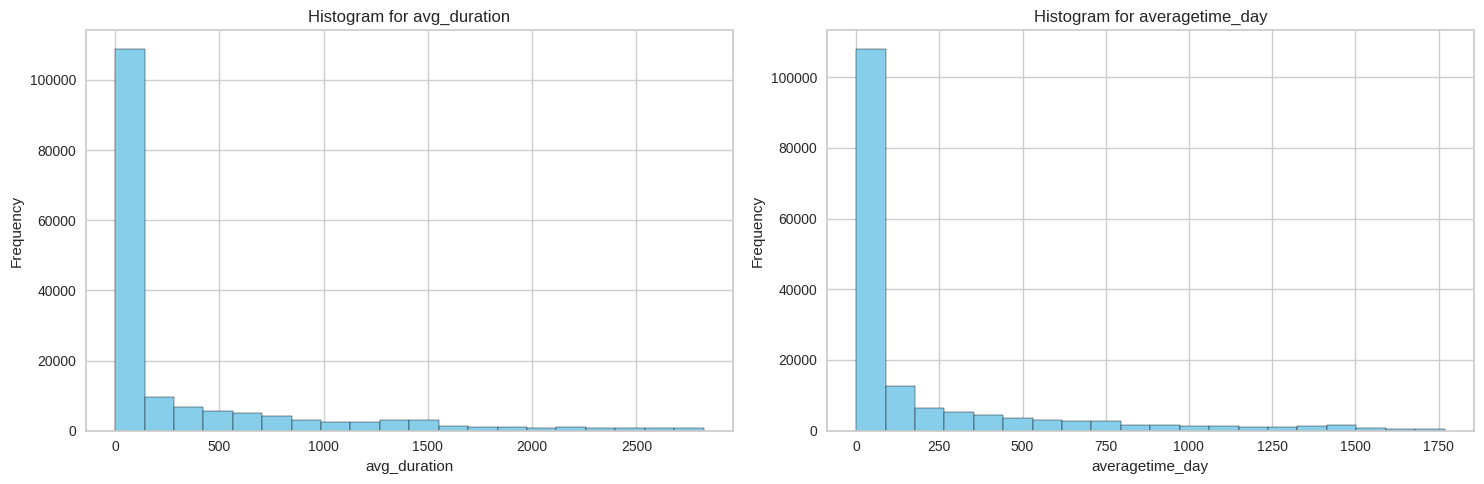

In [97]:
# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Flatten the 2D array into a 1D array
axes = axes.flatten()

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(df_selected):
    # Check if the column is numerical
    if df_selected[column].dtype in ['float64', 'int64']:
        axes[i].hist(df_selected[column], edgecolor='black', color='skyblue', bins=20)
        axes[i].set_title(f'Histogram for {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()



## **Handling Outliers and Robust Data Transformation**

for the same variables `average_duration`, `num_films`, `averagetime_day`, `gap_time_average`

Transformations like Box-Cox and logarithm are often used for various purposes in data analysis and statistics. Here are some common reasons for applying them:

1. **Normalization of Distributions**: Transformations can be used to make data distributions more symmetric and closer to a normal distribution. This is useful when applying statistical methods that assume a normal distribution of data.

2. **Variance Stabilization**: Some statistical models assume homoscedasticity, meaning that the variance of residuals is constant across all levels of the independent variable. Transformations can help stabilize the variance, addressing the issue of heteroscedasticity.

3. **Handling Non-linear Relationships**: If there is a non-linear relationship between variables, transformations can be used to make the relationship more linear. For example, a logarithmic transformation can be useful when the relationship between variables is exponential.

4. **Reducing the Effect of Outliers**: Transformations can mitigate the impact of outliers on the data distribution. For instance, a logarithmic transformation can be useful in reducing the effect of extremely high values.

5. **Simplified Interpretation**: In some cases, transformations can make data more interpretable or simplify the understanding of relationships between variables.

It's important to note that the application of transformations depends on the specific nature of the data and the goals of the analysis. Before applying any transformation, it's advisable to carefully examine the data distribution and understand how the transformation will affect subsequent analyses.

Moreover, to address the impact of outliers on the integrity of our analysis, we choose to employ a robust approach by removing outliers based on quantile thresholds. This method allows us to focus on the majority of the data while mitigating the influence of extreme values that may distort the overall patterns. Despite the conventional wisdom that skewed data might not perform well in certain analyses, our case stands out as an exception. As evidenced by the plots, the application of quantile-based outlier removal not only ensures the reliability of the results but also demonstrates its appropriateness for handling the specific characteristics of our dataset. This nuanced approach underscores the importance of adapting methodologies to the unique features of the data at hand.

In [98]:
# Seleziona le colonne di interesse, inclusi "avg_duration" e "averagetime_day"
selected_columns = [ "avg_lentitle",  "avg_duration", "averagetime_day", "average_click", "count_notenglish", "num_films"]
# Iterate through selected columns

for column in selected_columns:
    # Apply the logarithmic transformation to the column
    transformed_data = np.log1p(allvariable2[column])

    # Create a new column in the DataFrame with the transformed values
    allvariable2[column] = transformed_data


Furthermore, it's worth noting that certain variables exhibit a normal or log-normal distribution. In light of this observation, we choose to address outliers to ensure the robustness of our analysis. The presence of outliers in the dataset, particularly in variables showcasing a skewed distribution, can disproportionately influence model performance. The decision to limit outliers is motivated by the desire to mitigate any undue impact on the results, as the data doesn't seem entirely consistent with high or otherwise anomalous values. Importantly, these outliers do not originate from our intermediate transformations but may reflect inherent variability within the dataset.

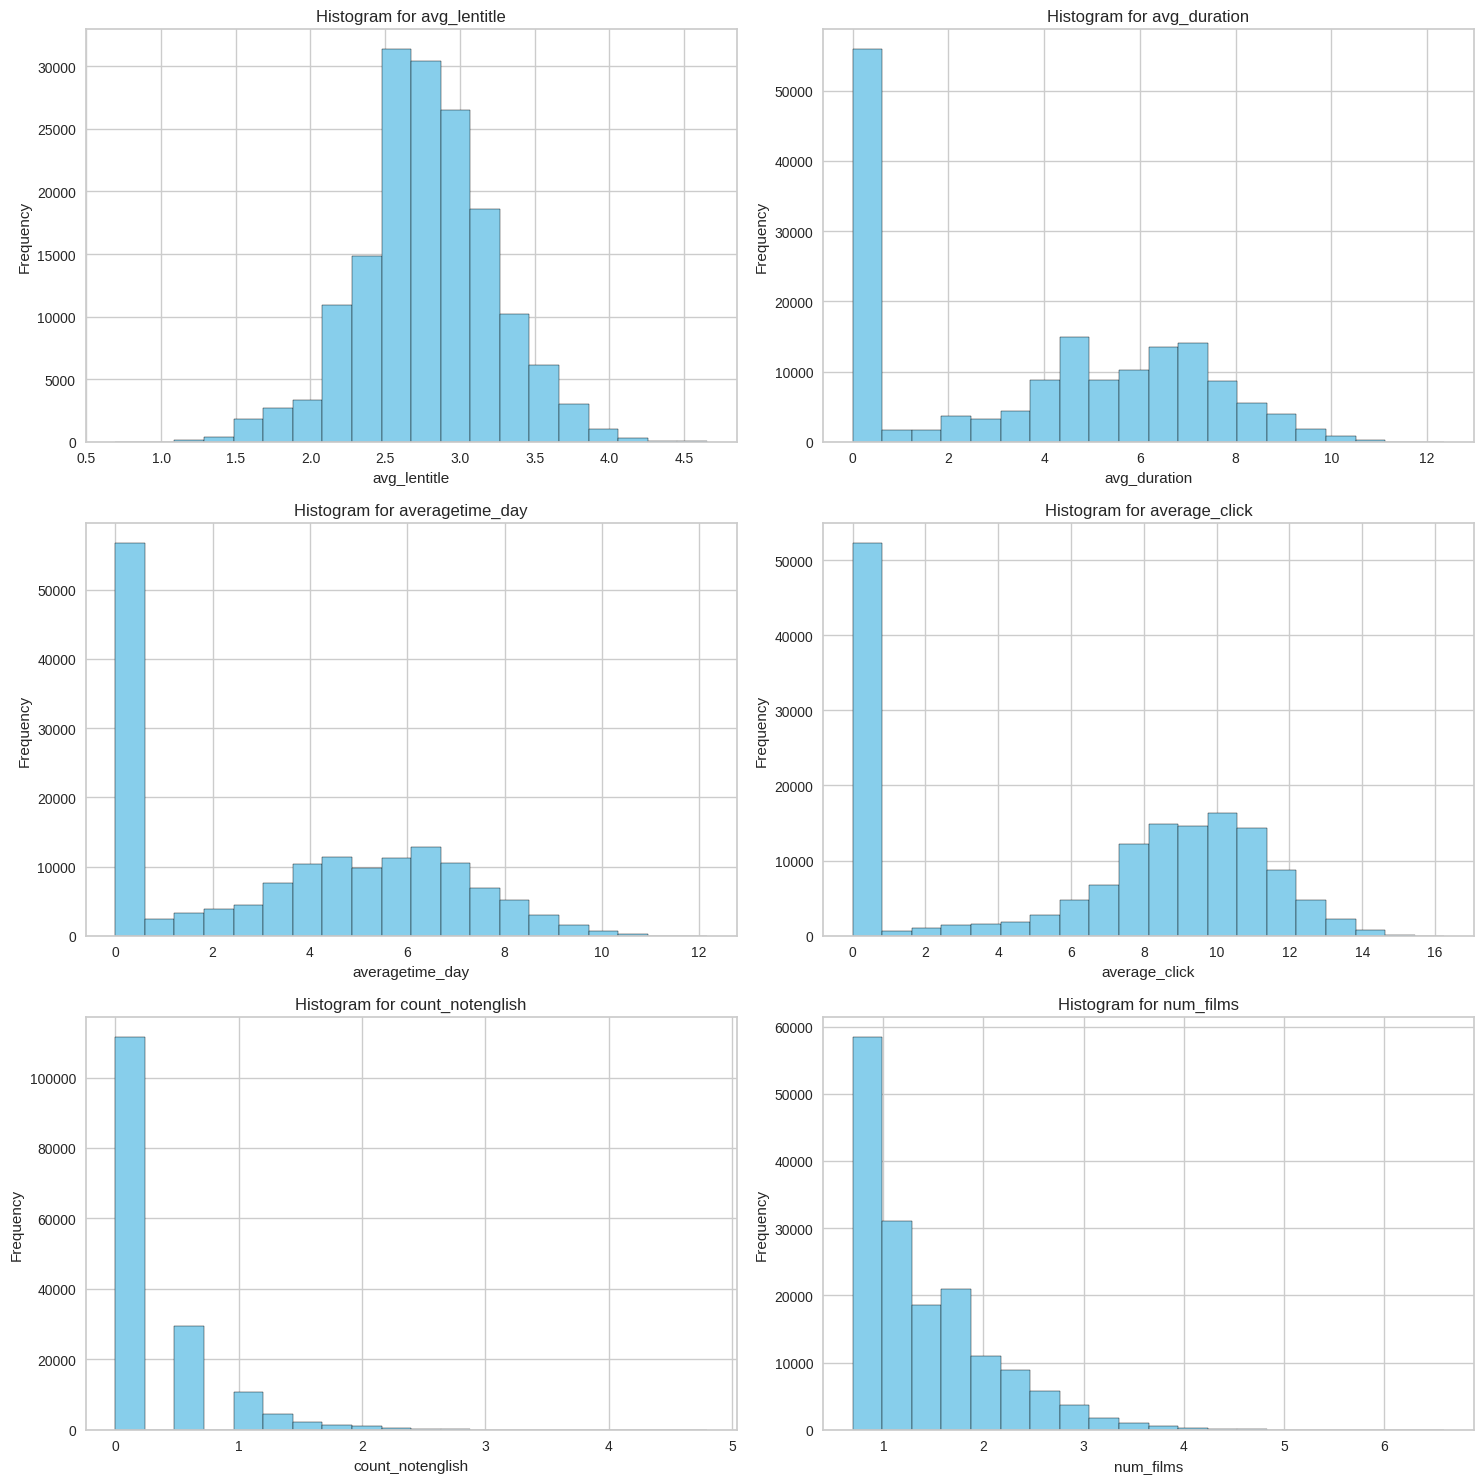

In [99]:
# Set the number of columns per row
columns_per_row = 2  # Adjust as needed

# Calculate the number of rows needed
num_rows = (len(selected_columns) + columns_per_row - 1) // columns_per_row

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(selected_columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row

    # Check if the column is numerical
    if allvariable2[column].dtype in ['float64', 'int64']:
        axes[row_index, col_index].hist(allvariable2[column], edgecolor='black', color='skyblue', bins=20)
        axes[row_index, col_index].set_title(f'Histogram for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Frequency')
    else:
        # For categorical columns, create a bar plot
        column_count = allvariable2[column].value_counts()
        column_count.plot(kind='bar', edgecolor='black', color='skyblue', ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'Bar Plot for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [100]:
allvariable2.to_json('/content/drive/MyDrive/ADM4/allvariables_outliers_log.json', orient='records', lines=True)

## **Normalization**

### To normalize or not to normalize

This is why we need to normalize the data. In general there are many more good reason to normalize:
- The mean performs poorly with outliers, which is not ideal as the mean constitutes a core aspect of all studies based on that statistic

- Imagine you have a dataset with features, and one feature has a much larger scale than the others then the mean of that particular feature contributes significantly to the overall mean of the dataset. If this feature is irrelevant or less informative, its inflated contribution to the mean might mislead the model. In regression analysis, the mean of the target variable serves as a fundamental baseline prediction.

- Mean Squared Error (MSE) acts as a pivotal metric, measuring the average squared difference between predicted and actual values. The lower MSE implies superior model performance compared to this basic mean-based prediction.

- **It is worth noting that the normalization process is context-dependent and contingent upon the specific variables involved**. In this particular instance, normalization is applied to some features will deepin later. Notably, the unit for this metric is significantly larger than that of other variables, such as the number of films. This normalization ensures a standardized comparison across diverse features, mitigating the potential bias introduced by varying scales in subsequent analyses.

Normalization is applied to the "average click gap," a measure denoting the time interval between successive clicks. This metric, quantified in milliseconds, possesses a considerably larger unit compared to other variables such as the number of films. Normalizing this parameter facilitates a consistent and unbiased evaluation, preventing the varying scales of these metrics from unduly impacting subsequent analyses.

The rationale behind normalization lies in the presence of diverse units of measurement and magnitudes within the dataset. For instance, we have averages in minutes, days, or absolute counts of films watched, all exhibiting varying scales. The range spans from 0-200 to 0-20,000. Normalization becomes crucial in this context to bring all features to a common scale, ensuring that the algorithm is not unduly influenced by the differences in magnitudes and enabling a fair comparison across diverse metrics.

In [101]:
file_path="/content/drive/MyDrive/ADM4/allvariables_outliers_log.json"

# Inizializza una lista per contenere i dati JSON
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Carica l'oggetto JSON dalla riga corrente
        data = json.loads(line)
        # Aggiungi l'oggetto alla lista
        data_list.append(data)


# Now 'data' is a list of JSON objects
allvariable3 = pd.DataFrame(data_list)

In [105]:
allvariable3['avg_clickgap'].fillna(allvariable3['avg_clickgap'].median(), inplace=True)
#allvariable3['genre_diversity'].fillna(allvariable3['genre_diversity'].median(), inplace=True)
allvariable3['gap_time_avg'].fillna(allvariable3['gap_time_avg'].median(), inplace=True)

In [106]:
# Verifica la presenza di NaN
print(allvariable3.isnull().sum())

average_click       0
oldmovie            0
averagetime_day     0
timeofday           0
weekend             0
count_notenglish    0
is_series           0
num_films           0
onefilm             0
avg_lentitle        0
avg_duration        0
genre_diversity     0
avg_clickgap        0
gap_time_avg        0
first_genre         0
dtype: int64


In [107]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max scaling to all numerical columns
allvariable3[allvariable3.columns] = scaler.fit_transform(allvariable3)


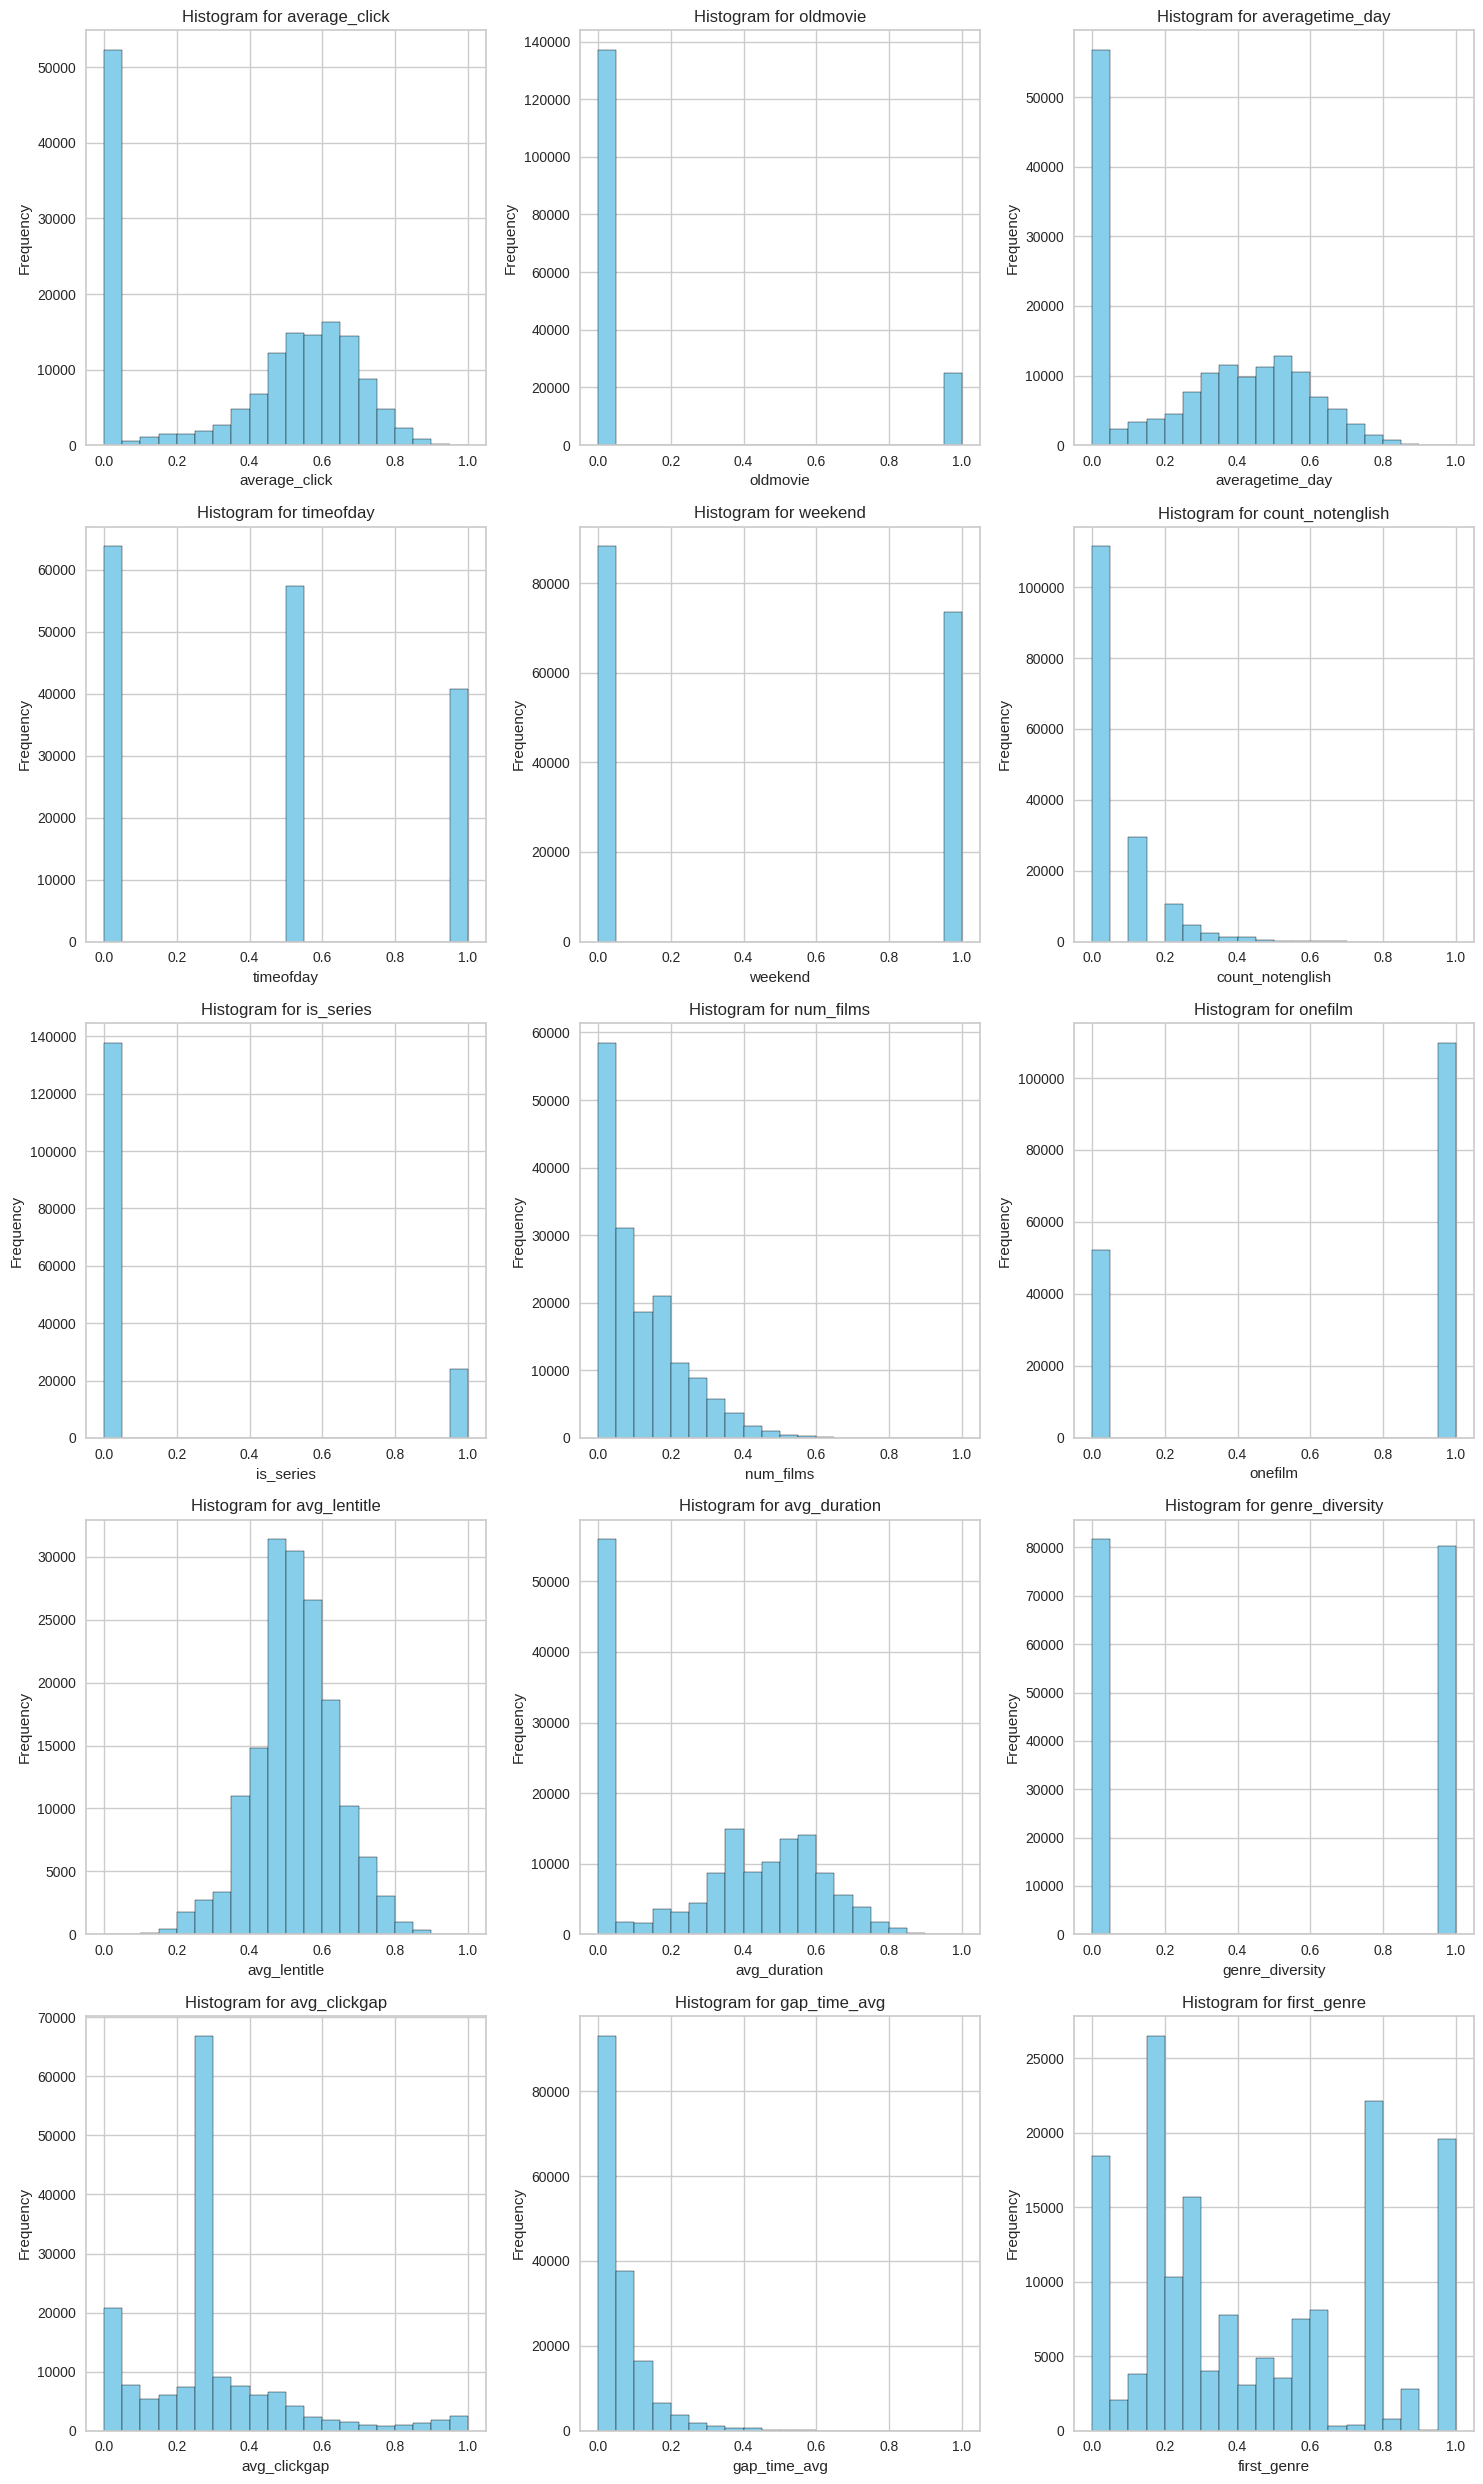

In [108]:
# Get the list of all columns
all_columns = allvariable3.columns

# Set the number of columns per row
columns_per_row = 3  # Adjust as needed

# Calculate the number of rows needed
num_rows = (len(all_columns) + columns_per_row - 1) // columns_per_row

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(all_columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row

    # Check if the column is numerical
    if allvariable3[column].dtype in ['float64', 'int64']:
        axes[row_index, col_index].hist(allvariable3[column], edgecolor='black', color='skyblue', bins=20)
        axes[row_index, col_index].set_title(f'Histogram for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Frequency')
    else:
        # For categorical columns, create a bar plot
        column_count = allvariable3[column].value_counts()
        column_count.plot(kind='bar', edgecolor='black', color='skyblue', ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'Bar Plot for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


# **2.2 matrix reduction dimensionality**

## **numerical variables**

In the pursuit of enhancing the robustness and interpretability of our analytical framework, we opted to normalize all data, including categorical variables. This decision was driven by the desire to bring all features to a common scale, ensuring a balanced influence on the modeling process irrespective of the original measurement units. Normalizing categorical variables is particularly valuable in scenarios where these features exhibit varying magnitudes or scales. Additionally, the application of Principal Component Analysis (PCA) was deemed essential for dimensionality reduction. By transforming the dataset into a set of uncorrelated variables, or principal components, PCA not only aids in simplifying the model but also contributes to the identification of the most influential features. This reduction in dimensionality is pivotal for enhancing computational efficiency and mitigating the risk of overfitting, ultimately improving the model's generalizability to new data.

While the conventional approach of one-hot encoding was excluded due to the dimensions of our dataset, we acknowledge its significance. Therefore, we will address one-hot encoding separately for categorical variables, considering its application specifically to maintain the integrity and interpretability of these features.

In [109]:
numerical_var = allvariable3[['average_click','averagetime_day', 'count_notenglish', 'num_films',  'avg_lentitle',
       'avg_duration', 'avg_clickgap', 'gap_time_avg']]

In [192]:
pca = prince.PCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
pca = pca.fit(numerical_var)


In [148]:
pca.column_contributions_.style.format('{:.0%}')

component,0,1,2
variable,,,
average_click,50%,0%,0%
averagetime_day,50%,0%,0%
count_notenglish,0%,31%,9%
num_films,0%,41%,1%
avg_lentitle,0%,0%,36%
avg_duration,0%,26%,5%
avg_clickgap,0%,2%,45%
gap_time_avg,0%,0%,3%


## alla prima direzione contribuiscono average_click e averagetime_day

## alla seconda count_notenglish, numfilms, avg_duration

##alla terza avg_clickgap, avg_lengtitle

contibuiscono praticamente tutte tranne gap_time_avg

## tot.variability colta **solo delle numeriche** 60%

In [149]:
pca.eigenvalues_summary


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.973,24.67%,24.67%
1,1.851,23.14%,47.81%
2,1.050,13.12%,60.93%


In [150]:
pca.eigenvalues_

array([1.97326244, 1.85122968, 1.04976687])

In [151]:
pca.scree_plot()

alt.Chart(...)

In [152]:
pca.transform(numerical_var)

component,0,1,2
0,-1.761012,-1.505871,1.062679
1,0.310206,0.809401,-0.801430
2,-1.735577,1.096924,-0.691162
3,-1.720841,2.839026,-1.783134
4,0.834082,3.667336,-1.109085
...,...,...,...
161913,0.773988,-0.839462,-0.401679
161914,0.170814,-1.520222,-0.033100
161915,1.390514,-1.594024,-0.158686
161916,-1.744472,-0.475324,0.965897


In [153]:
pca.transform(numerical_var).equals(pca.row_coordinates(numerical_var))

True

In [154]:
pca.column_coordinates_

component,0,1,2
variable,,,
average_click,0.993229,-0.009237,0.001317
averagetime_day,0.993235,-0.008332,0.001195
count_notenglish,0.007942,0.754820,-0.310251
num_films,0.004890,0.867956,-0.102368
avg_lentitle,0.001068,0.003212,0.613990
avg_duration,0.011681,0.693097,0.239459
avg_clickgap,-0.004386,0.205759,0.689001
gap_time_avg,0.000203,0.072410,0.184344


## pca all variables

In [248]:
file_path="/content/drive/MyDrive/ADM4/allvariables_outliers_log.json"

# Inizializza una lista per contenere i dati JSON
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Carica l'oggetto JSON dalla riga corrente
        data = json.loads(line)
        # Aggiungi l'oggetto alla lista
        data_list.append(data)


# Now 'data' is a list of JSON objects
allvariable3 = pd.DataFrame(data_list)

## Handling categorical variables

In the process of normalization, we aim to convert the features into cardinal numerical values rather than ordinal ones, ensuring that the model comprehends the significance of the numerical differences between data points accurately. This approach becomes particularly relevant when dealing with features that represent counts, durations, or other quantitative measurements. Additionally, while normalization is a critical step, we have opted not to perform Principal Component Analysis (PCA) for dimensionality reduction by standardizing the data. This decision is driven by the desire to maintain the interpretability of the original features and prioritize a clear understanding of their individual contributions to the model. Instead, we will explore and compare the effectiveness of Multiple Correspondence Analysis (MCA) for handling categorical variables. Through MCA, categorical features will be transformed into one-hot encoded representations, facilitating their integration into the analysis alongside the numerical features.

In [249]:
# firstgenre
allvariable3['first_genre'] = allvariable3['first_genre'].map({"Action": 1, "Adventure": 2, 'Animation':3,
                                             'Biography':4, 'Comedy':5, 'Crime':6, 'Documentary':7,
                                              'Drama':8, 'Family':9, 'Fantasy':10,  'Film-Noir':11, 'History':12,
                                              'Horror':13, 'Music' : 14, 'Musical':15, 'Mystery':16, 'NOT AVAILABLE':17,
                                             'News':18, 'Reality-TV':19,  'Romance':20, 'Sci-Fi':21, 'Short':22,
                                              'Sport':23, 'Talk-Show':24, 'Thriller':25, 'War':26, 'Western':26})

# genre diversity
allvariable3['genre_diversity'] = allvariable3['genre_diversity'].map({"Not Genre Diverse": 0, "Genre Diverse": 1})

# oldmovie
allvariable3['oldmovie'] = allvariable3['oldmovie'].map({"newmovies": 0, "oldmovies": 1})

# weekend
allvariable3['weekend'] = allvariable3['weekend'].map({False: 0, True: 1})

# isseries
allvariable3['is_series'] = allvariable3['is_series'].map({False: 0, True: 1})

#onefilm
allvariable3['onefilm'] = allvariable3['onefilm'].map({False: 0, True: 1})

# timeofday
allvariable3['timeofday'] = allvariable3['timeofday'].map({"Morning": 1, "Afternoon": 2, "Night":3})

In [250]:
allvariable3.head()

,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg,first_genre
0,0.000000,0,0.000000,1,1,0.000000,0,0.693147,0,3.555348,0.000000,0,NaN,9.0,5
1,7.613407,0,3.825840,2,1,0.000000,1,2.564949,1,2.772589,5.052257,1,44.486,5.0,2
2,0.000000,0,0.000000,2,1,0.693147,1,1.945910,1,2.639057,4.667835,1,332.693,4.0,20
3,0.000000,0,0.000000,2,1,1.791759,1,2.772589,1,2.639057,3.477911,1,214.389,6.0,5
4,9.176215,0,4.972029,2,0,1.791759,1,3.295837,1,2.708050,4.984620,1,446.923,6.0,14


In [252]:
allvariable3['avg_clickgap'].fillna(allvariable3['avg_clickgap'].median(), inplace=True)
allvariable3['gap_time_avg'].fillna(allvariable3['gap_time_avg'].median(), inplace=True)

In [253]:
allvariable3.isna().sum()

average_click       0
oldmovie            0
averagetime_day     0
timeofday           0
weekend             0
count_notenglish    0
is_series           0
num_films           0
onefilm             0
avg_lentitle        0
avg_duration        0
genre_diversity     0
avg_clickgap        0
gap_time_avg        0
first_genre         0
dtype: int64

In [254]:
pca = prince.PCA(
    n_components=9,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
pca = pca.fit(allvariable3)


In [255]:
pca.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5,6,7,8
variable,,,,,,,,,
average_click,0%,50%,0%,0%,0%,0%,0%,0%,0%
oldmovie,0%,0%,0%,0%,0%,85%,15%,0%,0%
averagetime_day,0%,50%,0%,0%,0%,0%,0%,0%,0%
timeofday,16%,0%,15%,0%,1%,0%,0%,0%,0%
weekend,1%,0%,1%,17%,24%,0%,0%,6%,49%
count_notenglish,8%,0%,19%,1%,0%,0%,2%,2%,1%
is_series,4%,0%,16%,1%,6%,0%,1%,1%,2%
num_films,18%,0%,12%,0%,0%,0%,0%,0%,0%
onefilm,20%,0%,14%,0%,1%,0%,0%,0%,0%


 ## le variabili sono bilanciate e sono tipo 7 categoriali e 8 numeriche ma le prime sembrano cogliere molto di più. Queste infatti colgono una maggiore variabilità nelle prime dimensioni che sono quelle che er definizione colgono una variabilità maggiore delle altre.

 #### se dovessimo scegliere le variabili più influenti diremmo essere average_click, averagetime_day, timeofday,onefilm, genre_diversity (3 categriali e 2 numeriche)

 #first genre unica categoriale insieme avg_click e gap_time_Avg a contribuire meno ??

## in totale su tutte le variabili colgo il 85%

In [256]:
pca.eigenvalues_summary


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,3.425,22.83%,22.83%
1,1.973,13.16%,35.99%
2,1.387,9.25%,45.23%
3,1.061,7.07%,52.31%
4,1.050,7.00%,59.30%
5,1.001,6.68%,65.98%
6,0.992,6.61%,72.59%
7,0.933,6.22%,78.82%
8,0.922,6.15%,84.96%


In [257]:
pca.eigenvalues_

array([3.42460637, 1.97342114, 1.3869704 , 1.06093452, 1.0496978 ,
       1.00131653, 0.99214425, 0.9333994 , 0.92176244])

In [258]:
pca.scree_plot()

alt.Chart(...)

In [260]:
reduced_mat= pca.transform(allvariable3)

In [261]:
reduced_mat.head()

component,0,1,2,3,4,5,6,7,8
0,-2.591787,-1.735648,0.291610,1.906281,-0.435303,0.198553,-0.764885,-0.256552,-0.999598
1,1.774158,0.300931,1.241623,0.280132,-1.160397,0.325711,-0.323367,-1.599244,-1.139837
2,2.120883,-1.764374,1.695667,-0.239108,0.284312,0.220359,-0.539709,0.017542,-0.697253
3,2.787811,-1.761329,3.068804,-0.042458,-0.822186,0.622038,0.341221,-1.791048,-0.521046
4,3.358087,0.769914,3.031605,-0.726020,-1.130254,0.412794,-0.075941,-0.337330,1.229242


# **e se ne volessi solo 3**

In [263]:
pca = prince.PCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
pca = pca.fit(allvariable3)


In [264]:
pca.column_contributions_.style.format('{:.0%}')

component,0,1,2
variable,,,
average_click,0%,50%,0%
oldmovie,0%,0%,0%
averagetime_day,0%,50%,0%
timeofday,16%,0%,15%
weekend,1%,0%,1%
count_notenglish,8%,0%,19%
is_series,4%,0%,16%
num_films,18%,0%,12%
onefilm,20%,0%,14%


 ## le variabili sono bilanciate e sono tipo 7 categoriali e 8 numeriche ma le prime sembrano cogliere molto di più. Queste infatti colgono una maggiore variabilità nelle prime dimensioni che sono quelle che er definizione colgono una variabilità maggiore delle altre.

 #### se dovessimo scegliere le variabili più influenti diremmo essere average_click, averagetime_day, timeofday,onefilm, genre_diversity (3 categriali e 2 numeriche)

 #first genre unica categoriale insieme avg_click e gap_time_Avg a contribuire meno ??

## in totale su tutte le variabili colgo il 85%

In [265]:
pca.eigenvalues_summary


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,3.425,22.83%,22.83%
1,1.973,13.16%,35.99%
2,1.387,9.25%,45.23%


In [266]:
pca.eigenvalues_

array([3.42460637, 1.97342112, 1.38697004])

In [267]:
pca.scree_plot()

alt.Chart(...)

In [268]:
reduced_mat2= pca.transform(allvariable3)

In [269]:
reduced_mat2.head()

component,0,1,2
0,-2.591787,-1.735643,0.291570
1,1.774158,0.300935,1.241584
2,2.120882,-1.764383,1.695723
3,2.787810,-1.761343,3.068899
4,3.358087,0.769908,3.031646


## **categorial variables**

In [235]:
categorical_var = allvariable3[['oldmovie', 'timeofday', 'weekend','is_series', 'onefilm',
                              'genre_diversity','first_genre']]

In [236]:
mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(categorical_var)


In [237]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.316,6.70%,6.70%
1,0.160,3.39%,10.09%
2,0.145,3.07%,13.16%


In [238]:
mca.column_contributions_.style.format('{:.0%}')

,0,1,2
oldmovie_newmovies,0%,0%,0%
oldmovie_oldmovies,0%,1%,0%
timeofday_Afternoon,7%,10%,0%
timeofday_Morning,20%,6%,0%
timeofday_Night,6%,0%,0%
weekend_False,1%,1%,0%
weekend_True,1%,1%,0%
is_series_False,1%,2%,1%
is_series_True,5%,10%,6%
onefilm_False,23%,6%,0%


## risultati coerenti con la fca su tutte le variables. indeed timeofday, iseries, onefilm and generdiverse captures the higher variability

# FAMC

In [240]:
file_path="/content/drive/MyDrive/ADM4/allvariables_outliers_log.json"

# Inizializza una lista per contenere i dati JSON
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Carica l'oggetto JSON dalla riga corrente
        data = json.loads(line)
        # Aggiungi l'oggetto alla lista
        data_list.append(data)


# Now 'data' is a list of JSON objects
allvariable3 = pd.DataFrame(data_list)

In [242]:
allvariable3.head()

,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg,first_genre
0,0.000000,newmovies,0.000000,Morning,True,0.000000,False,0.693147,False,3.555348,0.000000,Not Genre Diverse,396.038,9.0,Comedy
1,7.613407,newmovies,3.825840,Afternoon,True,0.000000,True,2.564949,True,2.772589,5.052257,Genre Diverse,44.486,5.0,Adventure
2,0.000000,newmovies,0.000000,Afternoon,True,0.693147,True,1.945910,True,2.639057,4.667835,Genre Diverse,332.693,4.0,Romance
3,0.000000,newmovies,0.000000,Afternoon,True,1.791759,True,2.772589,True,2.639057,3.477911,Genre Diverse,214.389,6.0,Comedy
4,9.176215,newmovies,4.972029,Afternoon,False,1.791759,True,3.295837,True,2.708050,4.984620,Genre Diverse,446.923,6.0,Music


In [245]:
famd = prince.FAMD(
    n_components=9,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"
)
famd = famd.fit(allvariable3)

In [246]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,8.929,7.23%,7.23%
1,4.012,3.25%,10.48%
2,3.605,2.92%,13.40%
3,3.536,2.86%,16.26%
4,3.530,2.86%,19.12%
5,3.516,2.85%,21.97%
6,3.513,2.84%,24.81%
7,3.502,2.84%,27.65%
8,3.501,2.83%,30.48%


allvariable3.loc[[92929,126845,94849,83966,95654,41872,2351,140765,146469,152924]]

## questa analisi coglie molto meno variabilità addiritura meno di quanto ne coglie la pca con 3 variabili mentre qui ne stiamo usando 9 dove la pca osserva l'85%

# to resume we end u choosing the pca considering the variable as numeric with coherent transformation. We save that information in a dataframe

In [262]:
reduced_mat.to_json('/content/drive/MyDrive/ADM4/reduced9.json', orient='records', lines=True)

In [ ]:
reduced_mat.to_json('/content/drive/MyDrive/ADM4/reduced9.json', orient='records', lines=True)